In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import sounddevice as sd

In [2]:
import matplotlib.pyplot as plt
from IPython import display
from tensorflow.keras import layers
from tensorflow.keras import models
%matplotlib inline

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf_records = ["data/raw/" + filename for filename in os.listdir("./data/raw")]
tf_records

['data/raw/nsynth-test.tfrecord-00000-of-00008',
 'data/raw/nsynth-test.tfrecord-00001-of-00008',
 'data/raw/nsynth-test.tfrecord-00002-of-00008',
 'data/raw/nsynth-test.tfrecord-00003-of-00008',
 'data/raw/nsynth-test.tfrecord-00004-of-00008',
 'data/raw/nsynth-test.tfrecord-00005-of-00008',
 'data/raw/nsynth-test.tfrecord-00006-of-00008',
 'data/raw/nsynth-test.tfrecord-00007-of-00008']

In [5]:
raw_dataset = tf.data.TFRecordDataset(tf_records)
raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [6]:
info = pd.DataFrame(columns=["instrument_family", "instrument_source", "instrument", "pitch", "note"])
audio = []
for raw_record in raw_dataset.take(-1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  row = [ 
    example.features.feature["instrument_family"].int64_list.value[0],
    example.features.feature["instrument_source"].int64_list.value[0],
    example.features.feature["instrument"].int64_list.value[0],
    example.features.feature["pitch"].int64_list.value[0],
    example.features.feature["note"].int64_list.value[0] 
  ]
  info.loc[len(info)] = row
  audio.append(example.features.feature["audio"].float_list.value)

In [16]:
audio = np.array(audio)
sr = 16000
sd.play(audio[4], sr)

In [23]:
info_train = info[:3072]
info_test = info[3072:]
audio_train = audio[:3072]
audio_test = audio[3072:]

In [8]:
sources = ["acoustic", "electronic", "synthetic"]
families = ["bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "synth_lead", "vocal"]

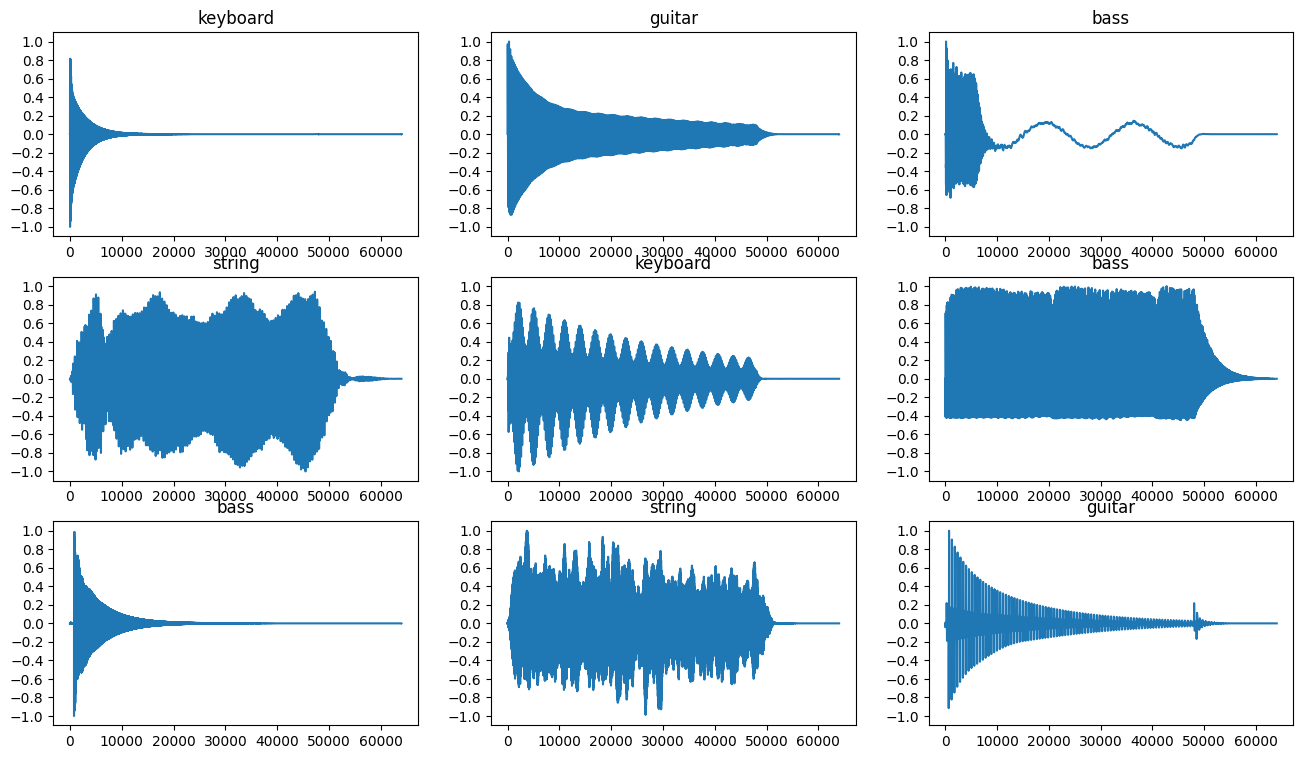

In [9]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio_train[i])
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = families[info_train["instrument_family"][i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

In [10]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [26]:
for i in range(3):
  label = families[info_train["instrument_family"][i]]
  waveform = audio_train[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: keyboard
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


Label: guitar
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


Label: bass
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


In [27]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

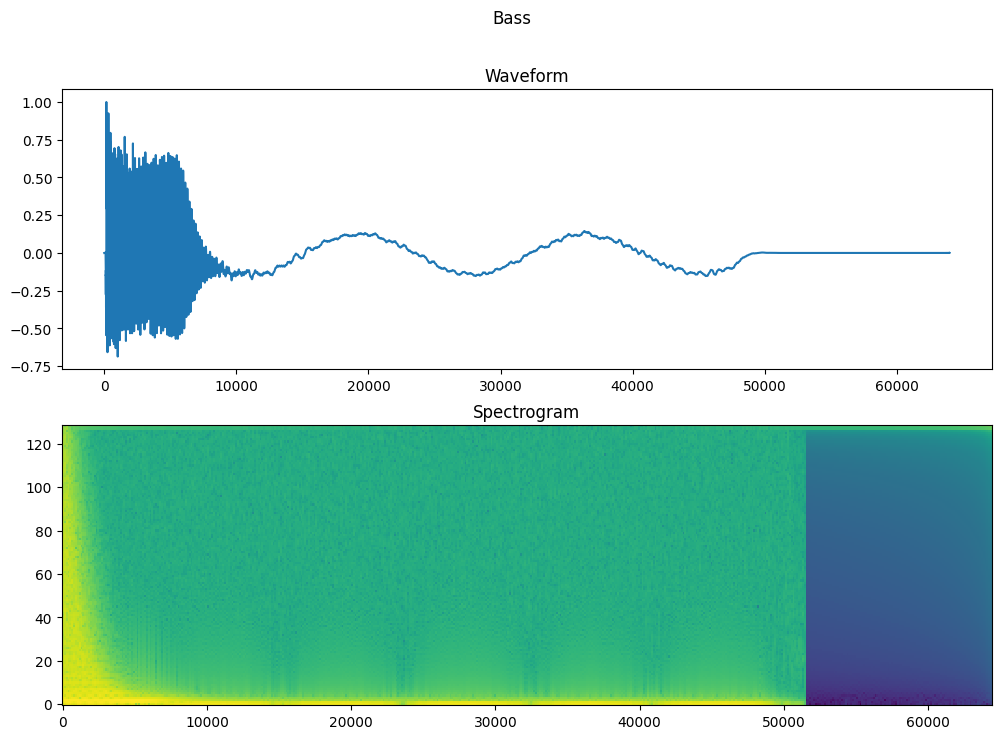

In [28]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform)
axes[0].set_title('Waveform')
# axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [29]:
spectrograms_train = [get_spectrogram(waveform) for waveform in audio_train]
spectrograms_test = [get_spectrogram(waveform) for waveform in audio_test]

In [30]:
labels_train = info_train["instrument_family"].to_list()
labels_test = info_test["instrument_family"].to_list()

In [31]:
spectrograms_train = tf.convert_to_tensor(spectrograms_train)
spectrograms_test = tf.convert_to_tensor(spectrograms_test)
labels_train = tf.convert_to_tensor(labels_train)
labels_test = tf.convert_to_tensor(labels_test)

In [32]:
print(spectrograms_train.shape)
print(labels_train.shape)
print(spectrograms_test.shape)
print(labels_test.shape)

(3072, 499, 129, 1)
(3072,)
(1024, 499, 129, 1)
(1024,)


In [53]:
input_shape = spectrograms_train.shape[1:-1]
print('Input shape:', input_shape)
num_labels = len(families)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrograms_train)

model = models.Sequential([
    layers.Input(shape=(None, None, 1)),
    # Downsample the input.
    layers.Resizing(*input_shape),
    # Normalize.
    norm_layer,
    # layers.Conv2D(32, 3, activation='relu'),
    # layers.Conv2D(64, 3, activation='relu'),
    # layers.MaxPooling2D(),
    # layers.Dropout(0.25),
    layers.Flatten(),
    # layers.Dense(128, activation='relu'),
    # layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (499, 129)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_5 (Resizing)       (None, 499, 129, 1)       0         
                                                                 
 normalization_11 (Normaliza  (None, 499, 129, 1)      3         
 tion)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 64371)             0         
                                                                 
 dense_7 (Dense)             (None, 11)                708092    
                                                                 
Total params: 708,095
Trainable params: 708,092
Non-trainable params: 3
_________________________________________________________________


In [54]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [55]:
EPOCHS = 50
history = model.fit(
    x=spectrograms_train,
    y=labels_train,
    validation_data=(spectrograms_test, labels_test),
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/50
96/96 [==============================] - 4s 32ms/step - loss: 6.0741 - accuracy: 0.4167 - val_loss: 4.8626 - val_accuracy: 0.4883
Epoch 2/50
96/96 [==============================] - 3s 29ms/step - loss: 3.7835 - accuracy: 0.5804 - val_loss: 4.7582 - val_accuracy: 0.5635
Epoch 3/50
96/96 [==============================] - 3s 30ms/step - loss: 2.5597 - accuracy: 0.6527 - val_loss: 3.7091 - val_accuracy: 0.6455
Epoch 4/50
96/96 [==============================] - 3s 29ms/step - loss: 1.7794 - accuracy: 0.7207 - val_loss: 3.7870 - val_accuracy: 0.6367
Epoch 5/50
96/96 [==============================] - 3s 29ms/step - loss: 1.5511 - accuracy: 0.7526 - val_loss: 3.1447 - val_accuracy: 0.6543
Epoch 6/50
96/96 [==============================] - 3s 29ms/step - loss: 1.4364 - accuracy: 0.7790 - val_loss: 3.1624 - val_accuracy: 0.6914
Epoch 7/50
96/96 [==============================] - 3s 29ms/step - loss: 1.1695 - accuracy: 0.8018 - val_loss: 3.7865 - val_accuracy: 0.6689
Epoch 7: earl

Text(0, 0.5, 'Accuracy [%]')

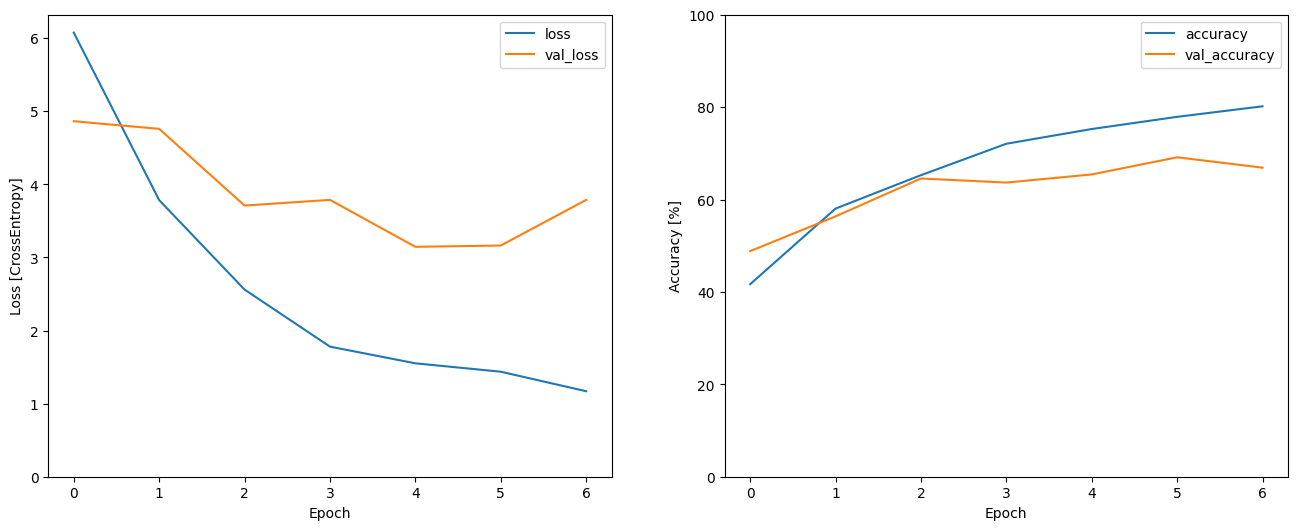

In [56]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [29]:
# model.save("./models/model2")

INFO:tensorflow:Assets written to: ./models/model2\assets


INFO:tensorflow:Assets written to: ./models/model2\assets


In [30]:
# model = tf.keras.models.load_model("./models/model2")

In [44]:
x = tf.io.read_file("./samples/piano-G3.wav")
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

In [45]:
prediction = model(x)

In [46]:
prediction

<tf.Tensor: shape=(1, 11), dtype=float32, numpy=
array([[ 1.5312138 , -2.5981364 , -0.73002565,  0.48466676,  2.4094381 ,
         0.8876189 , -0.5535162 , -3.757273  , -1.843349  , -6.57991   ,
        -3.4927995 ]], dtype=float32)>

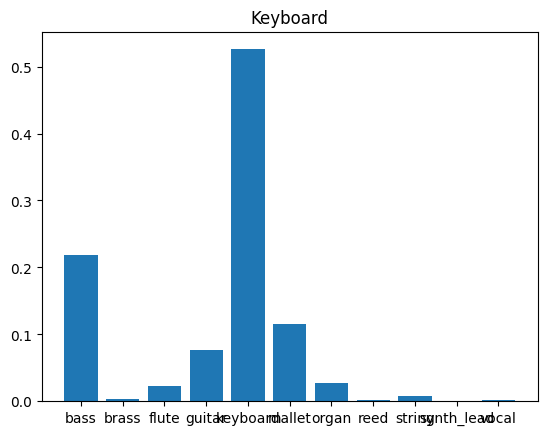

In [49]:
plt.bar(families, tf.nn.softmax(prediction[0]))
plt.title('Keyboard')
plt.show()

display.display(display.Audio(waveform, rate=16000))